# Transformers - Speech commands classification with Transformers

## Code/Data-Preparation

In [16]:
# Install dependencies
! pip install librosa
! pip install numpy
! pip install matplotlib
! pip install seaborn
! pip install scikit-learn
! pip install scipy

! pip install tensorflow --upgrade
! pip install tensorflow-io
! pip install keras --upgrade

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.1 MB 1.7 MB/s eta 0:00:01
   ----------------- ---------------------- 0.5/1.1 MB 5.0 MB/s eta 0:00:01
   ---------------------------------------  1.1/1.1 MB 7.0 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.2
    Uninstalling keras-3.3.2:
      Successfully uninstalled keras-3.3.2


In [5]:
# Please read the guidelines on https://www.kaggle.com/docs/api#authentication
# to get an idea where to put your kaggle API token to be able to download the dataset

! pip install kaggle
! kaggle competitions download -c "tensorflow-speech-recognition-challenge"

! tar -xf tensorflow-speech-recognition-challenge.zip -C ../data/challenge
! del tensorflow-speech-recognition-challenge.zip

# To extract the dataset, we need to have 7-zip (https://www.7-zip.org/) installed and added to our $PATH
! 7z x -o..\data\challenge ..\data\challenge\test.7z
! 7z x -o..\data\challenge ..\data\challenge\train.7z



  0%|          | 0.00/3.50G [00:00<?, ?B/s]
  0%|          | 1.00M/3.50G [00:00<39:21, 1.59MB/s]
  0%|          | 2.00M/3.50G [00:00<20:06, 3.12MB/s]
  0%|          | 4.00M/3.50G [00:00<09:25, 6.65MB/s]
  0%|          | 6.00M/3.50G [00:00<06:31, 9.60MB/s]
  0%|          | 8.00M/3.50G [00:01<05:35, 11.2MB/s]
  0%|          | 10.0M/3.50G [00:01<05:00, 12.5MB/s]
  0%|          | 12.0M/3.50G [00:01<04:38, 13.5MB/s]
  0%|          | 14.0M/3.50G [00:01<04:25, 14.1MB/s]
  0%|          | 16.0M/3.50G [00:01<04:18, 14.5MB/s]
  1%|          | 18.0M/3.50G [00:01<04:00, 15.5MB/s]
  1%|          | 21.0M/3.50G [00:01<03:35, 17.3MB/s]
  1%|          | 23.0M/3.50G [00:02<03:30, 17.7MB/s]
  1%|          | 25.0M/3.50G [00:02<03:28, 17.9MB/s]
  1%|          | 27.0M/3.50G [00:02<03:28, 17.9MB/s]
  1%|          | 29.0M/3.50G [00:02<03:30, 17.8MB/s]
  1%|          | 31.0M/3.50G [00:02<03:35, 17.3MB/s]
  1%|          | 34.0M/3.50G [00:02<03:13, 19.3MB/s]
  1%|          | 36.0M/3.50G [00:02<03:22, 18.4MB/s]
 


7-Zip 23.01 (x64) : Copyright (c) 1999-2023 Igor Pavlov : 2023-06-20

Scanning the drive for archives:
1 file, 2640679130 bytes (2519 MiB)

Extracting archive: ..\data\challenge\test.7z
--
Path = ..\data\challenge\test.7z
Type = 7z
Physical Size = 2640679130
Headers Size = 1345163
Method = Delta LZMA2:24
Solid = +
Blocks = 3

Everything is Ok

Folders: 2
Files: 158538
Size:       5080191672
Compressed: 2640679130

7-Zip 23.01 (x64) : Copyright (c) 1999-2023 Igor Pavlov : 2023-06-20

Scanning the drive for archives:
1 file, 1121103842 bytes (1070 MiB)

Extracting archive: ..\data\challenge\train.7z
--
Path = ..\data\challenge\train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

Everything is Ok

Folders: 33
Files: 64732
Size:       2055161498
Compressed: 1121103842


In [31]:
# Imports
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from pathlib import Path
from scipy.io import wavfile
from scipy import signal
import librosa

import numpy as np
import shutil

import tensorflow as tf
import keras
from keras import layers, models
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Exploration

In [2]:
train_path = Path(Path('.').resolve().parent, "data/challenge/train/audio/")

### Visualisation
To check if data is of the expected format, we visualise characteristics some example file. The code for this part is adapted from https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration

In [3]:
# Define and open file to visualise
file_to_visualise = "yes/0a7c2a8d_nohash_0.wav"
filepath = Path(train_path, file_to_visualise)
sample_rate, data = wavfile.read(filepath)
sample_rate

16000

### Wave and spectrogram

Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear. We need to assure that there are no 0 values as input to logarithm.


(From https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=5)


In [28]:
# Define a function that calculates spectrogram. (https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=6)
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

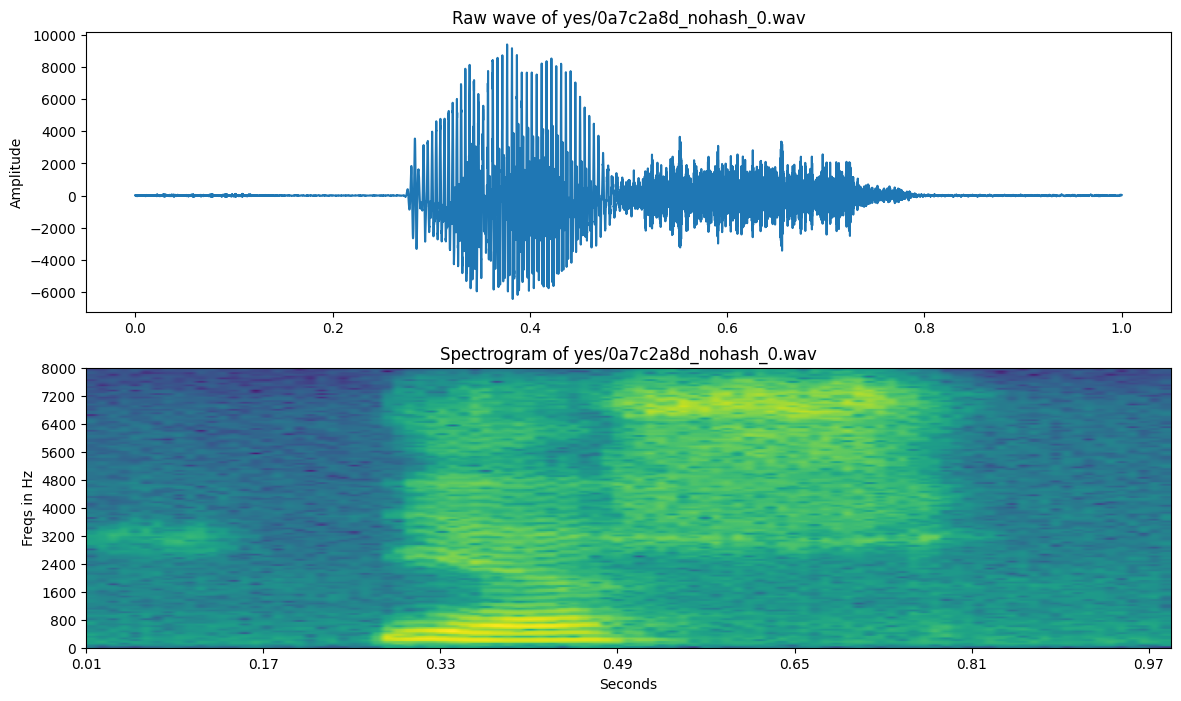

In [46]:
freqs, times, spectrogram = log_specgram(data, sample_rate)

def plot_wave_spectrogram(data, sample_rate):
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of ' + file_to_visualise)
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, sample_rate/len(data), sample_rate), data)

    ax2 = fig.add_subplot(212)
    ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
            extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax2.set_yticks(freqs[::16])
    ax2.set_xticks(times[::16])
    ax2.set_title('Spectrogram of ' + file_to_visualise)
    ax2.set_ylabel('Freqs in Hz')
    ax2.set_xlabel('Seconds')

plot_wave_spectrogram(data, sample_rate)

In [47]:
# Normalise spectrogram to be suitable as input for neuronal network
# https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=10
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

### Mel Frequency Cepstral Coefficient (MFCC)
MFCCs are used in speach recognition approaches.  They are a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. (https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

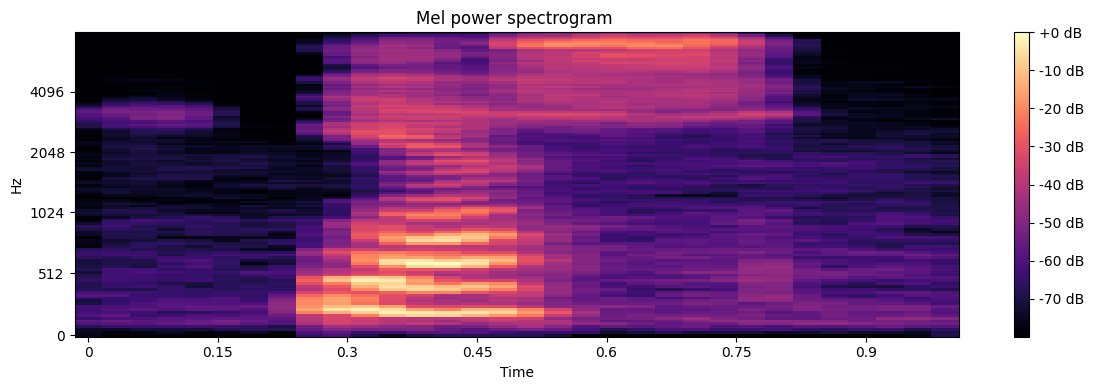

In [55]:
# Calculate the Mel power spectrogram

# https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=13
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(y=data.astype(np.float32), sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

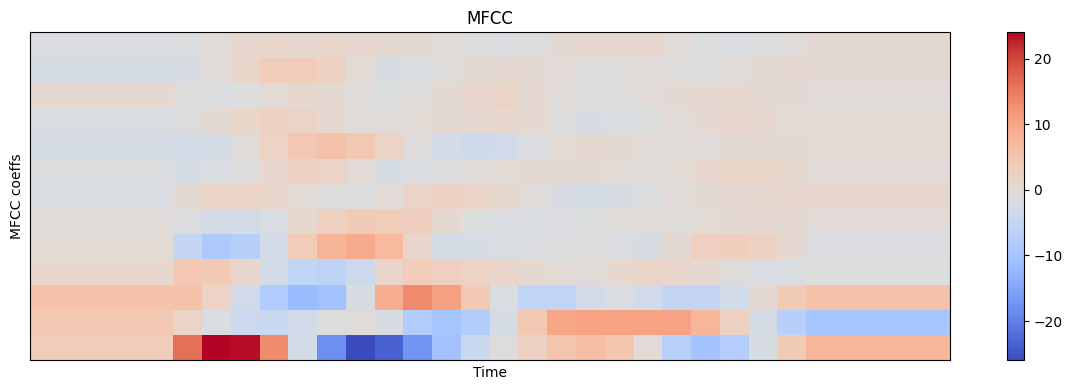

In [56]:
# Calculate MFCC
# https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=14

mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In classical, but still state-of-the-art systems, MFCC or similar features are taken as the input to the system instead of spectrograms.

However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example MFCC decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters, you may consider their usage sensible.

From: https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=15

### Detect silence
Despite our audio samples are only 1 second long, they still include some silence. Removing that silence would decrease our training size. We should use VAD (Voice Activity Detection) for that, but that is not a priority for now and more a proposal for future work.

In [63]:
# Example audio
ipd.Audio(data=data, rate=sample_rate)

In [65]:
# Cut audio 
data_cut = data[4000:13000]
ipd.Audio(data_cut, rate=sample_rate)
# Still entire word can be heard, but audio is 7000 samples shorter

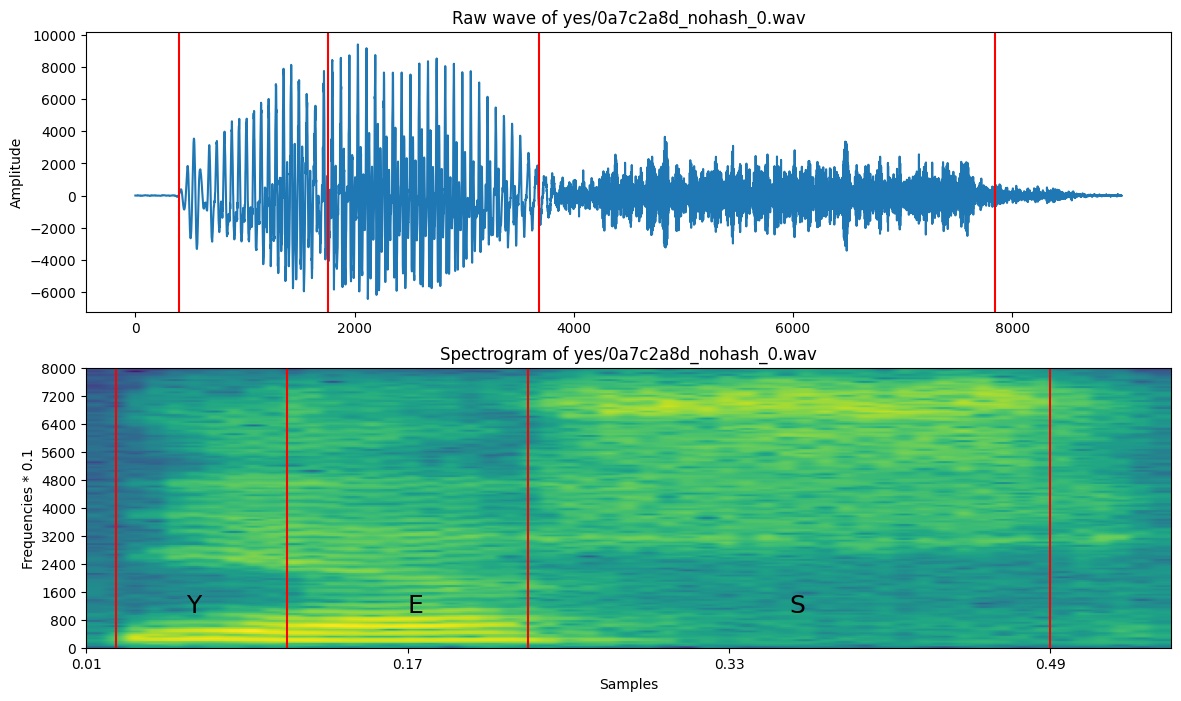

In [68]:
# Visualise silence cut
# https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=24
freqs, times, spectrogram_cut = log_specgram(data_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + file_to_visualise)
ax1.set_ylabel('Amplitude')
ax1.plot(data_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + file_to_visualise)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

### Resampling
We could also resample our dataset to 8000 Hz as described in https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=25 to reduce the size of or dataset even further, but this is out of our scope for now.

## Dataset Exploration

In [79]:
# Get labels
labels = []
for label in train_path.iterdir():
    if label.is_dir():
        labels.append(label.name)

print(labels)
print("Number of labels:", len(labels))

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero', '_background_noise_']
Number of labels: 31


Text(0.5, 1.0, 'Number of recordings in each Category')

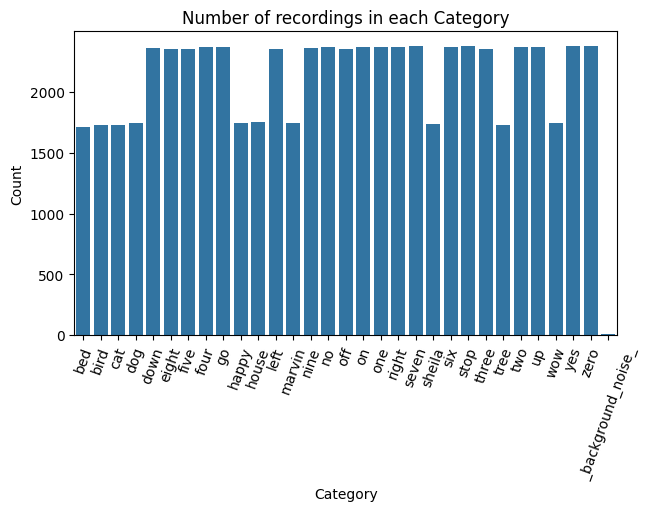

In [92]:
# Plot number of recordings per label
dataset_spectro = {}
for label in labels:
    dataset_spectro[label] = 0

for label in train_path.iterdir():
    if label.is_dir():
        for item in label.iterdir():
            if item.suffix == ".wav":
                dataset_spectro[label.name] += 1

sns.barplot(dataset_spectro)
plt.xticks(rotation=70)
plt.tight_layout()
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Number of recordings in each Category")

### Record length

In [95]:
shorter_count = 0
for label in train_path.iterdir():
    if label.is_dir():
        for item in label.iterdir():
            if item.suffix == ".wav":
                sample_rate, data = wavfile.read(item)
                if data.shape[0] < sample_rate:
                    shorter_count += 1
print("Number of recordings shorter than one second:", shorter_count)

Number of recordings shorter than one second: 6469


C:\Users\Lukas\AppData\Local\Temp\ipykernel_6632\3651088838.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(item)


We need padding!

### Waveplot for every word

C:\Users\Lukas\AppData\Local\Temp\ipykernel_27152\4043068661.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(14, 8))


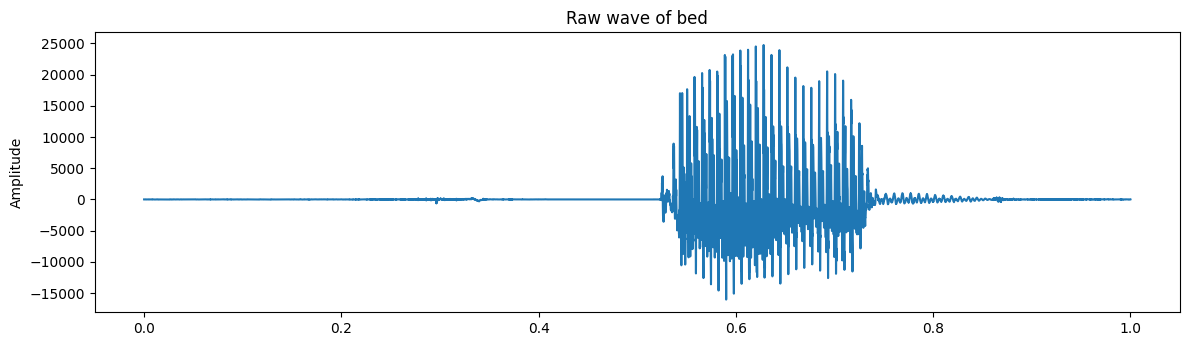

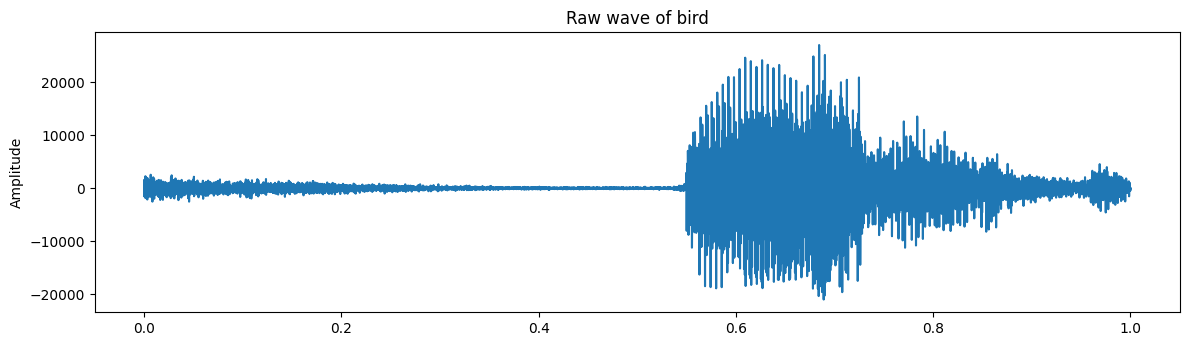

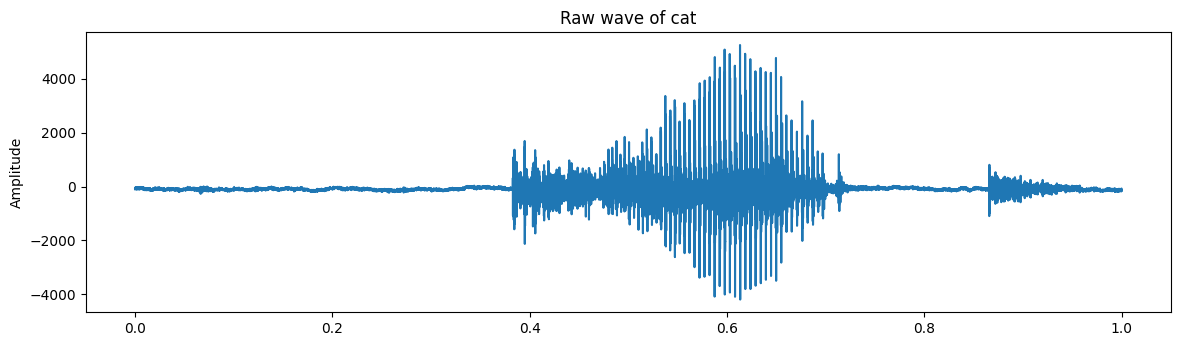

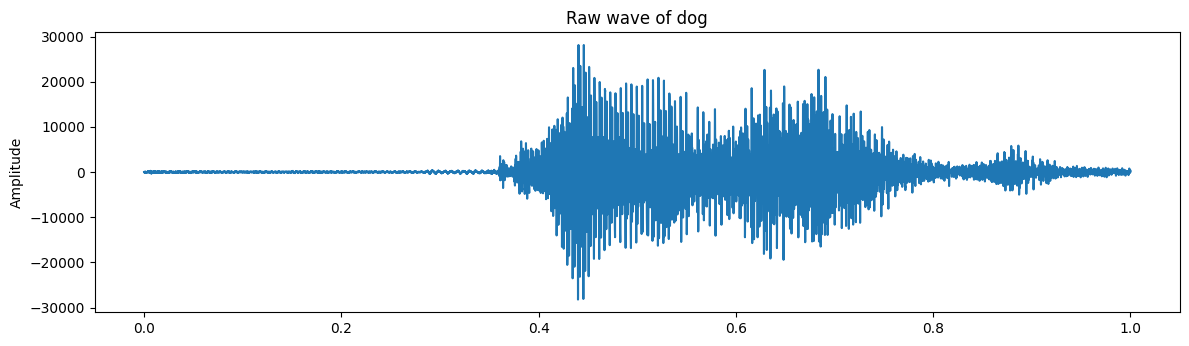

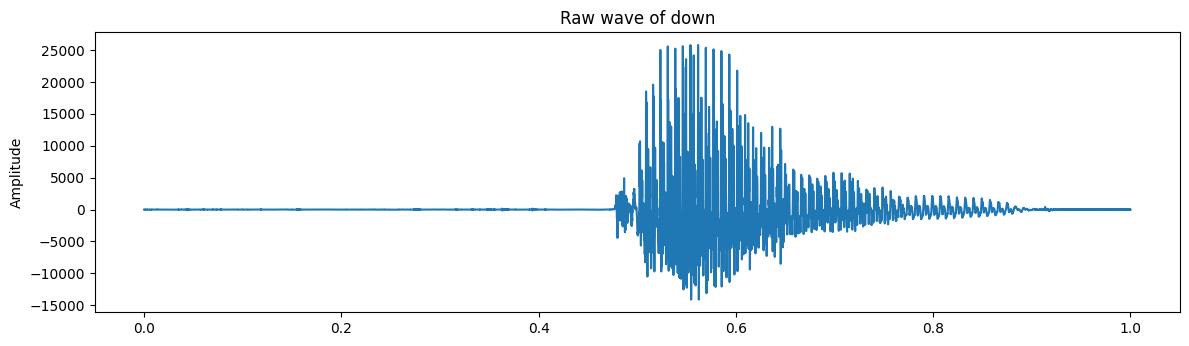

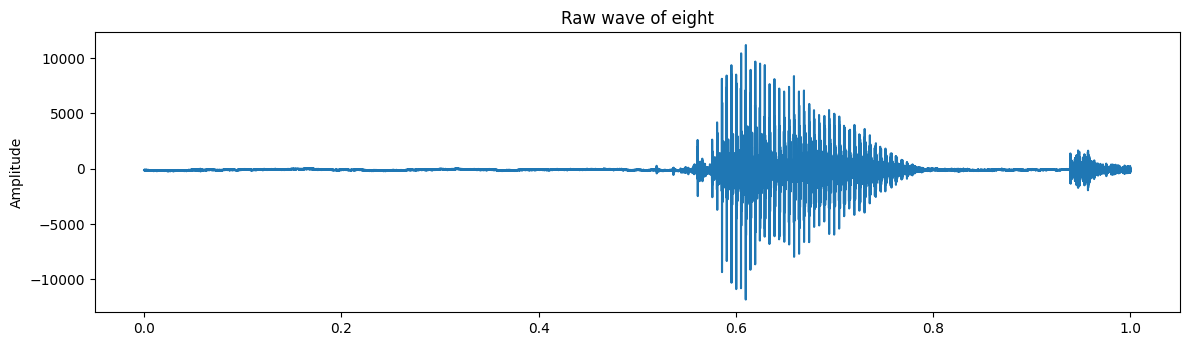

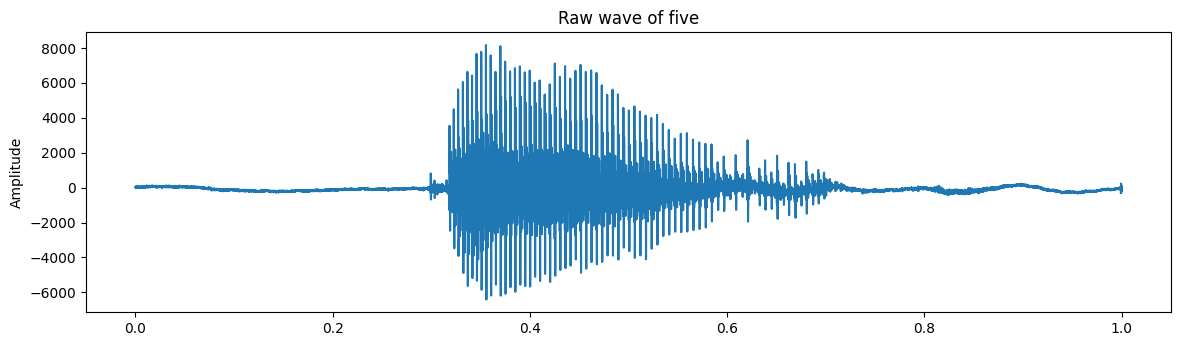

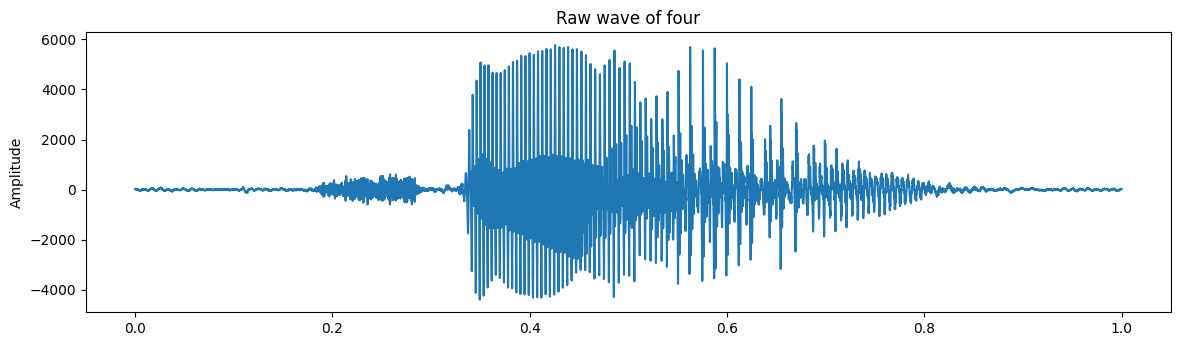

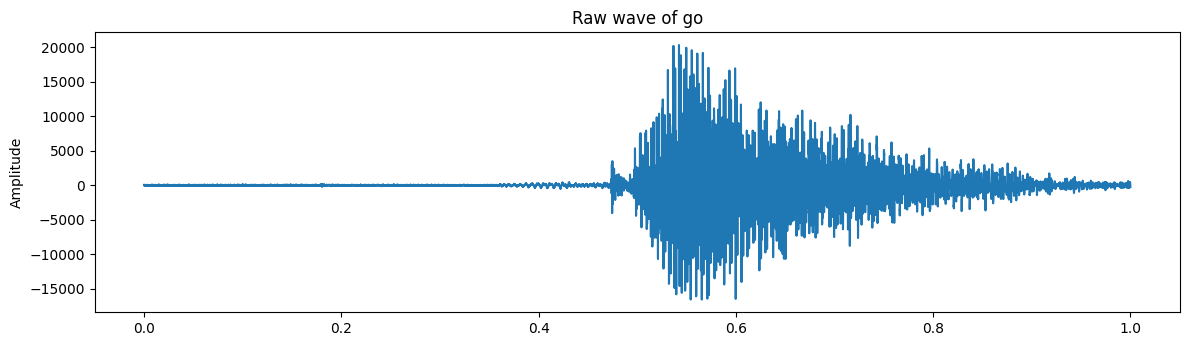

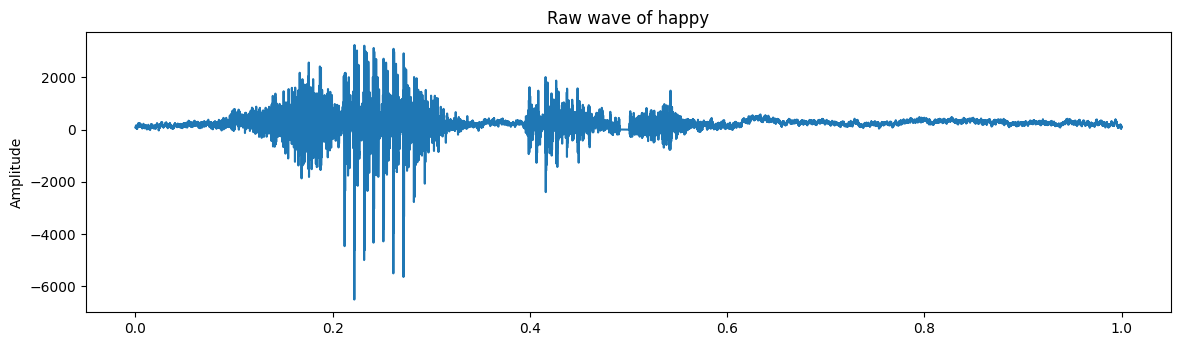

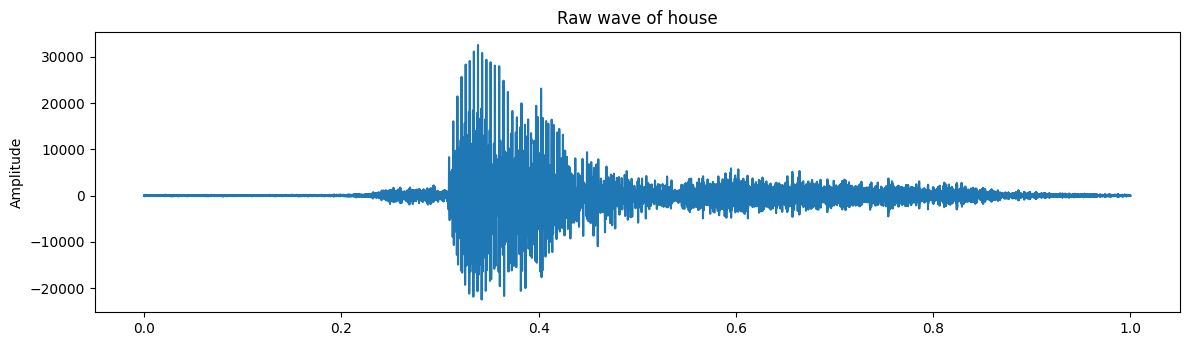

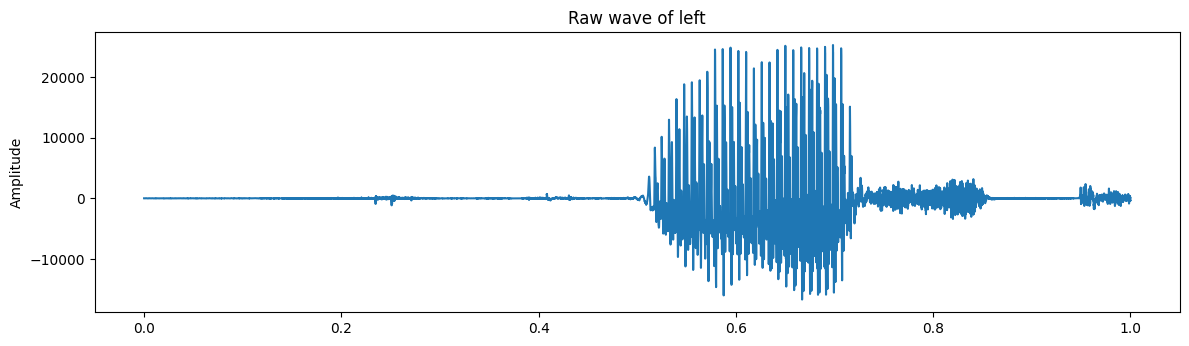

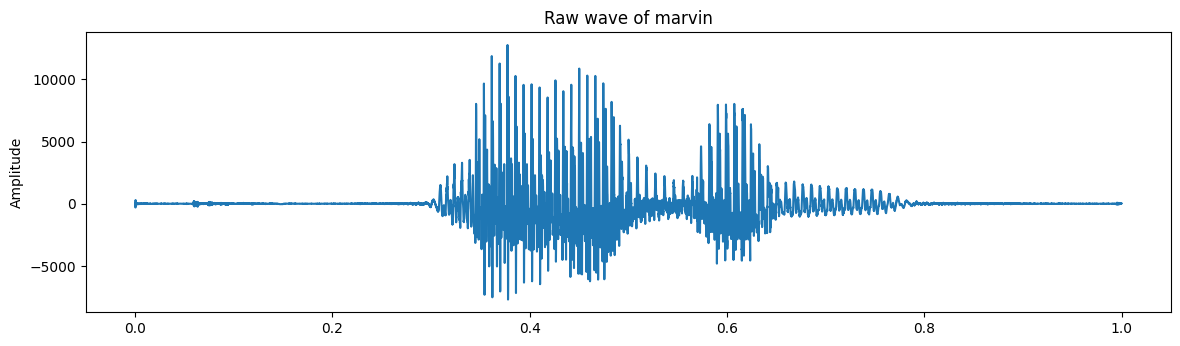

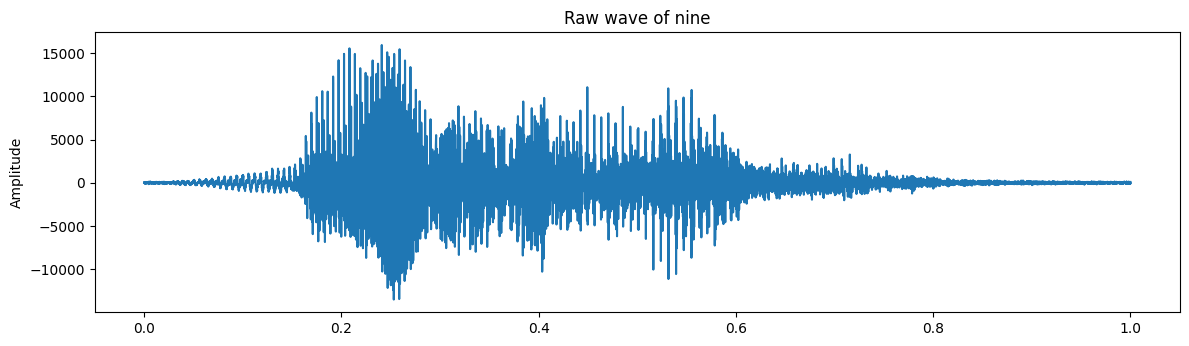

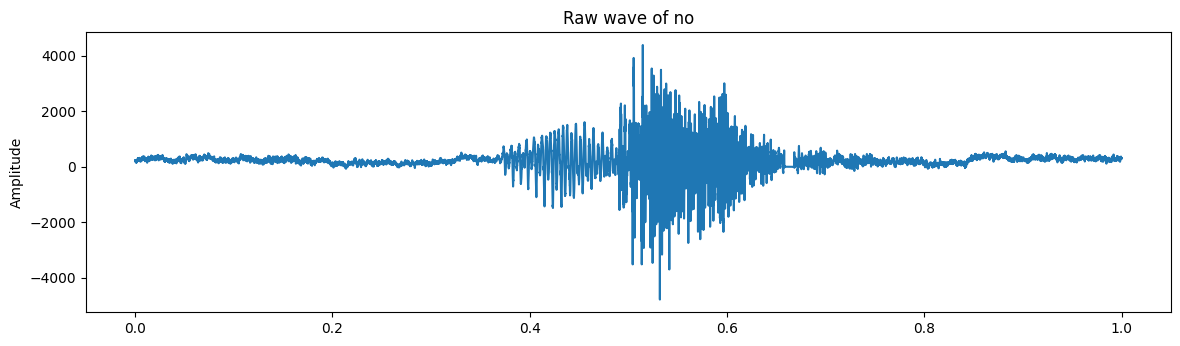

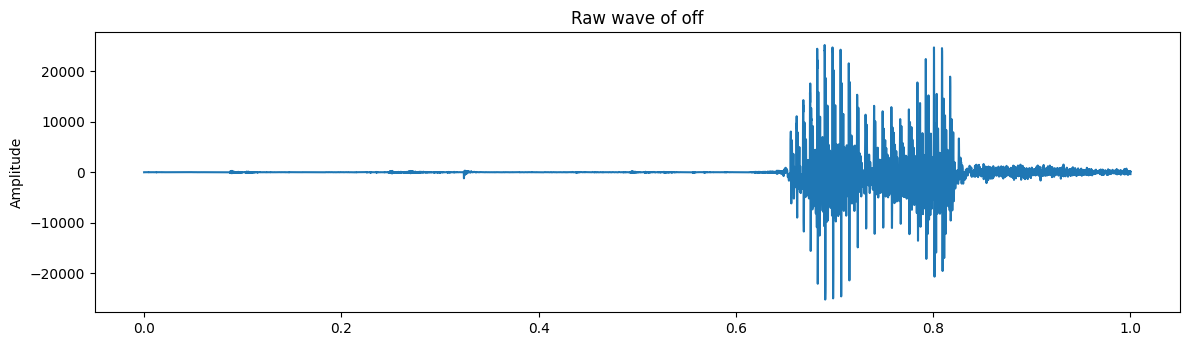

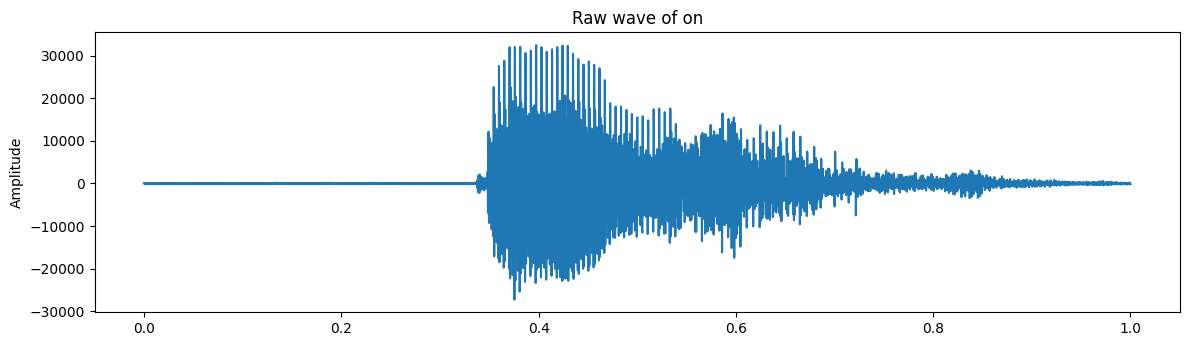

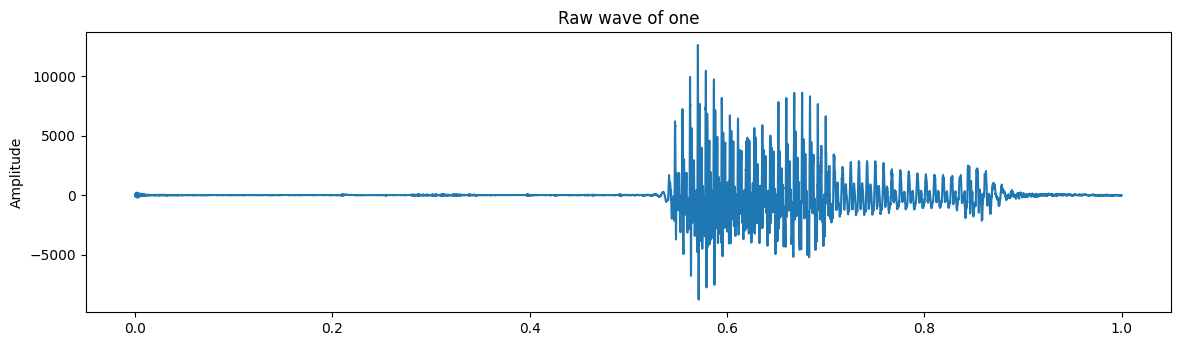

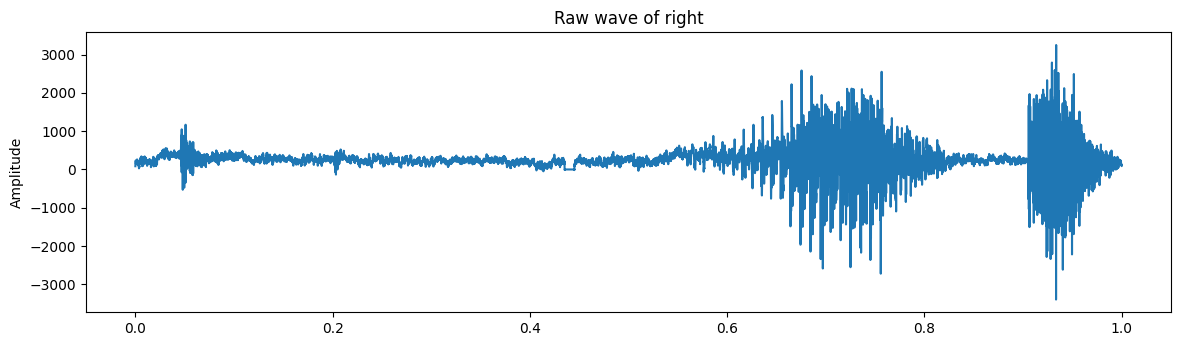

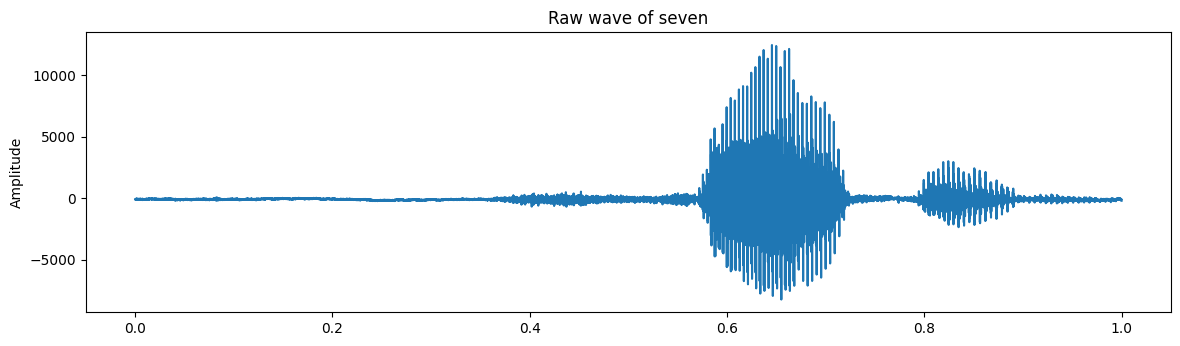

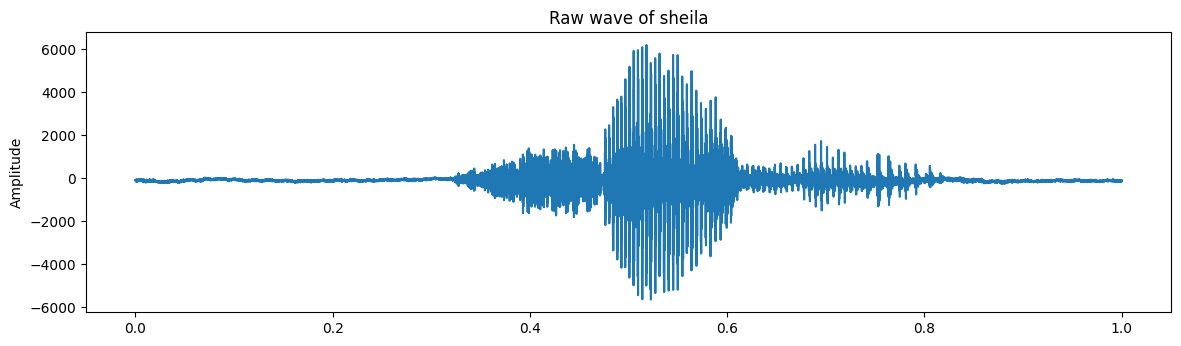

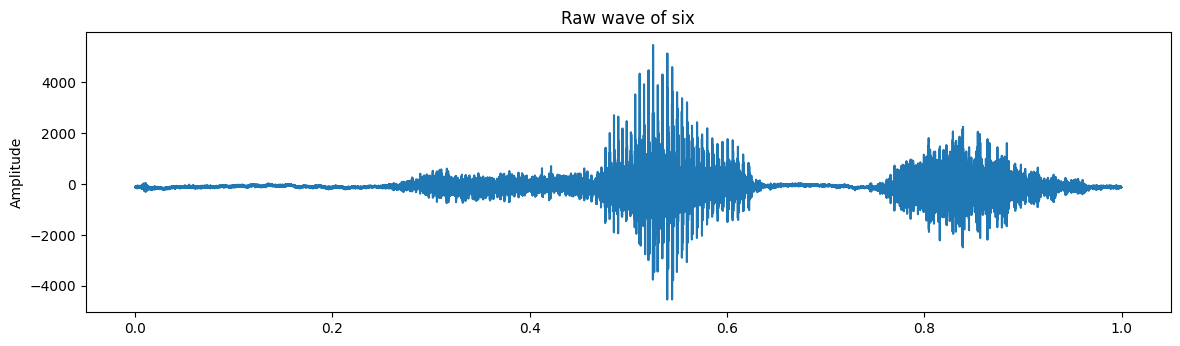

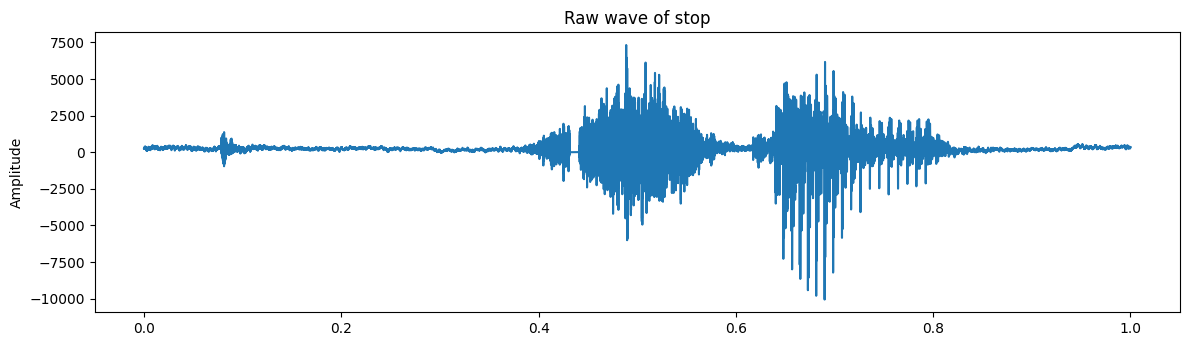

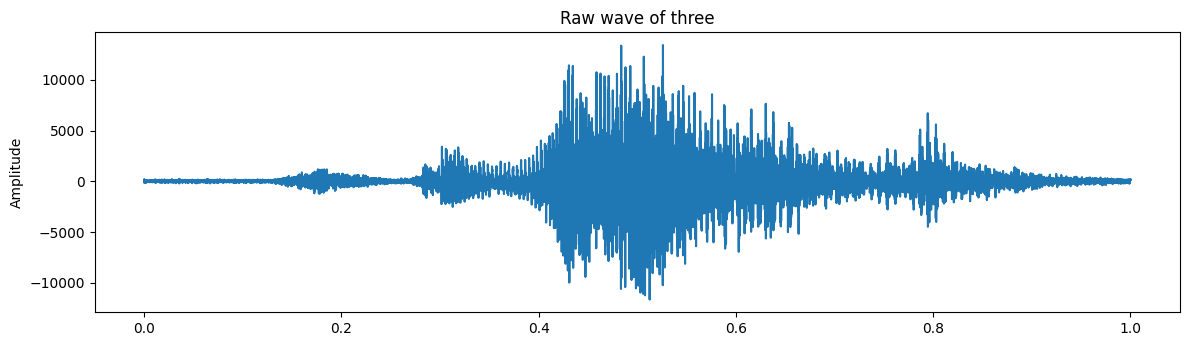

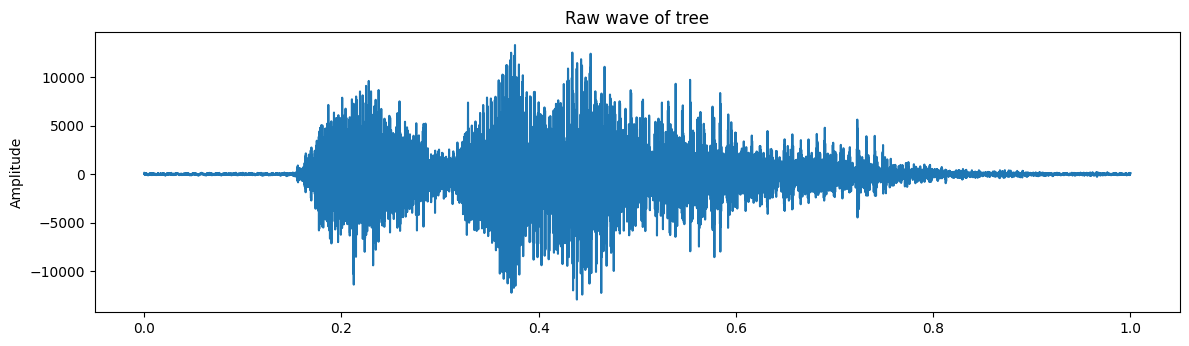

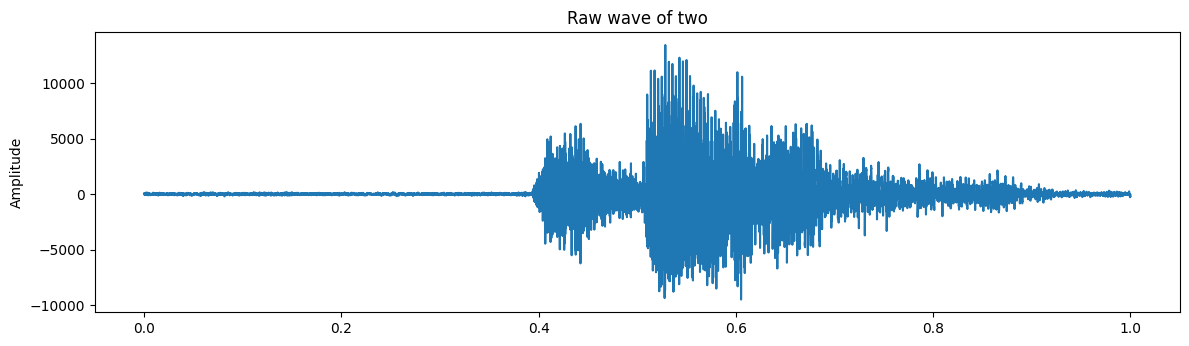

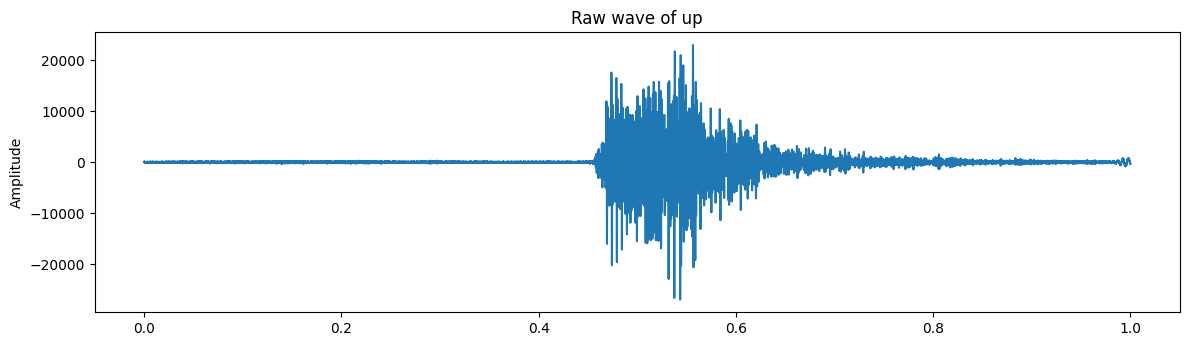

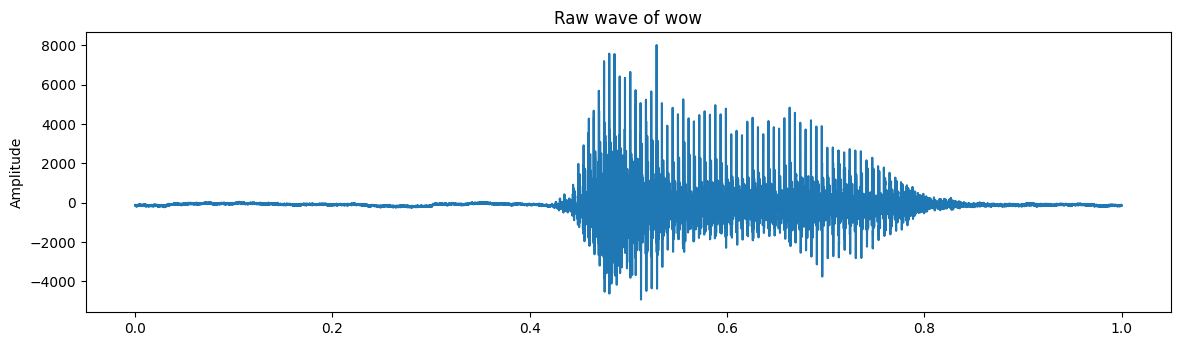

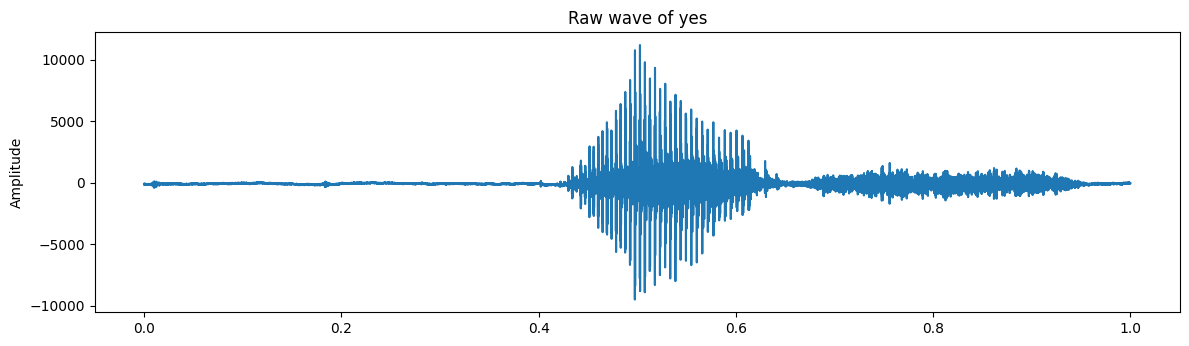

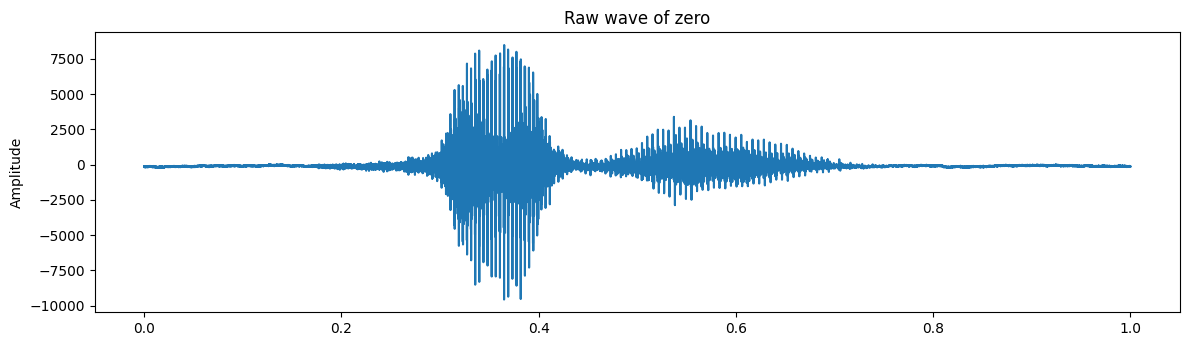

In [13]:
example_data = []
example_label = []
for label in train_path.iterdir():
    if label.is_dir():
        if label.name == "_background_noise_":
            continue
        for item in label.iterdir():
            if item.suffix == ".wav":
                sample_rate, data = wavfile.read(item)
                if data.shape[0] != 16000:
                    continue
                example_data.append(data)
                example_label.append(label.name)
                break


# plt.figure(figsize=(16, 10))
# rows = 3
# cols = 3
# n = rows * cols
for data, label in zip(example_data, example_label):
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of ' + label)
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, 16000/len(data), 16000), data)

### Mean spectrograms

In [97]:
dataset_spectro = {}
for label in labels:
    dataset_spectro[label] = []

for label in train_path.iterdir():
    if label.is_dir():
        if label.name == "_background_noise_":
            continue
        for item in label.iterdir():
            if item.suffix == ".wav":
                sample_rate, data = wavfile.read(item)
                if data.shape[0] != 16000:
                    continue
                freqs, times, spectro = log_specgram(data, 16000)
                dataset_spectro[label.name].append(spectro)            

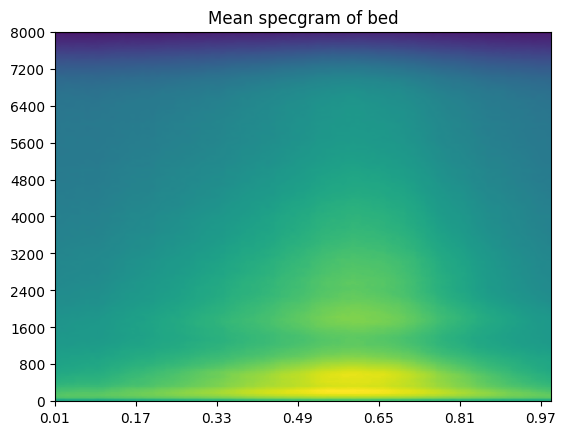

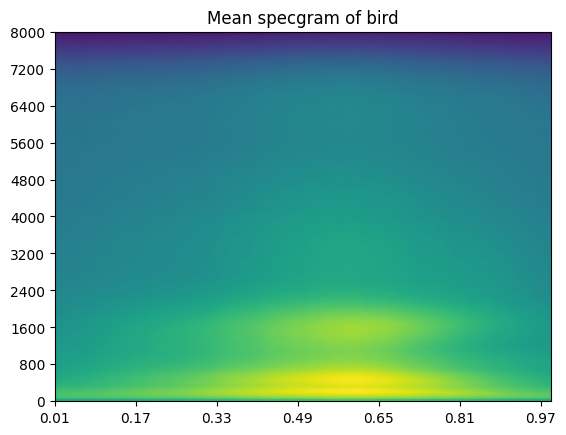

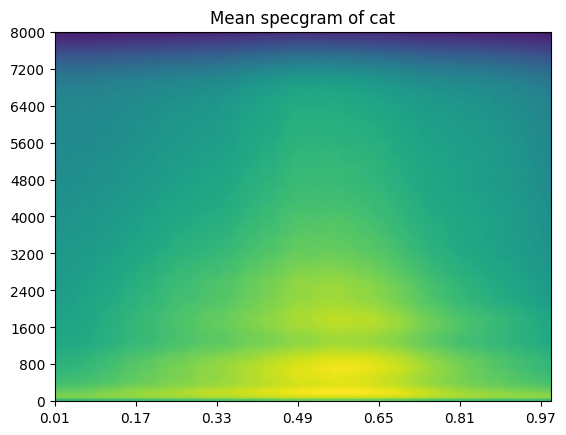

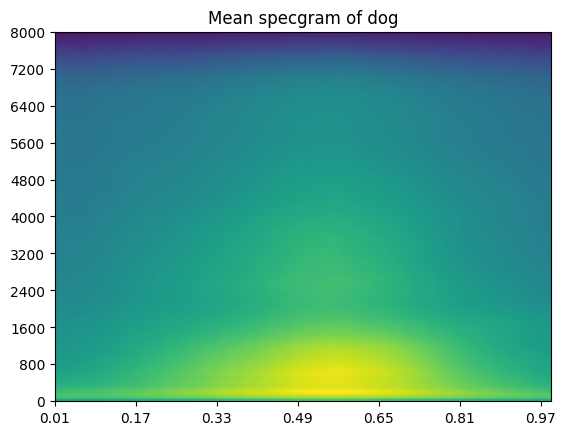

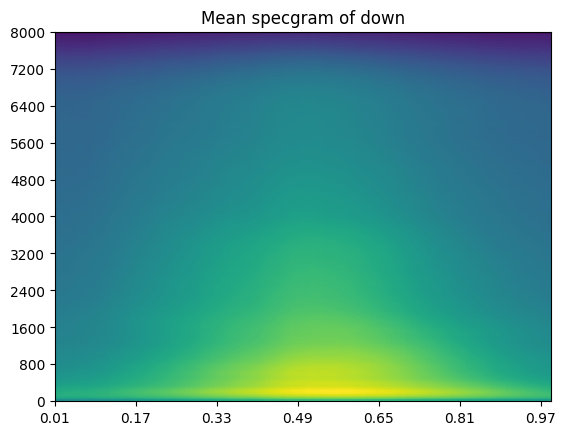

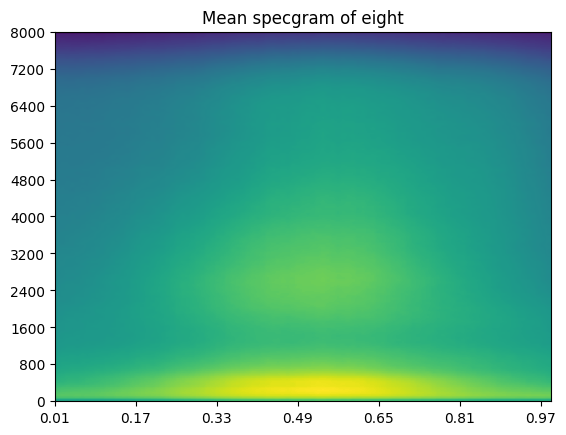

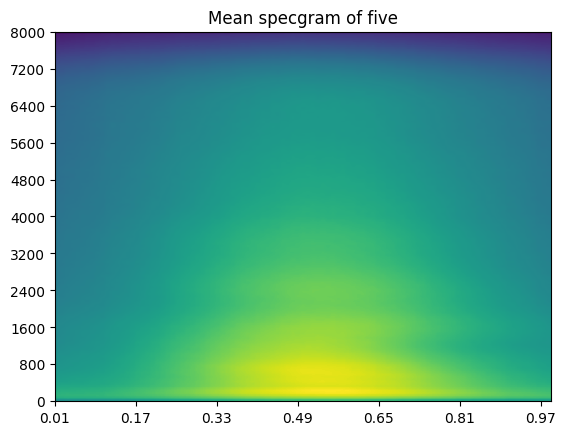

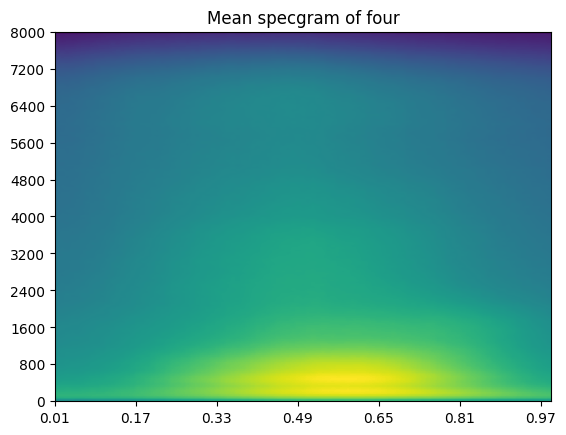

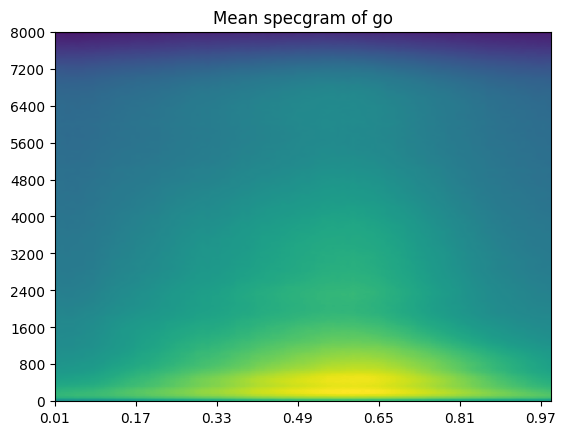

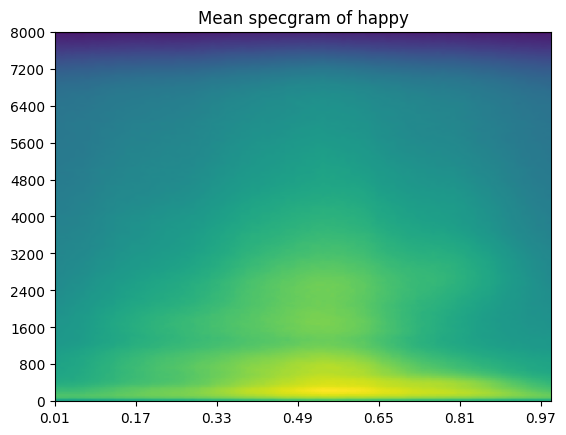

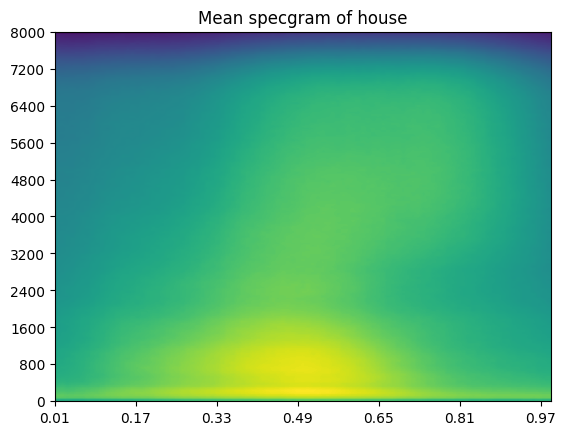

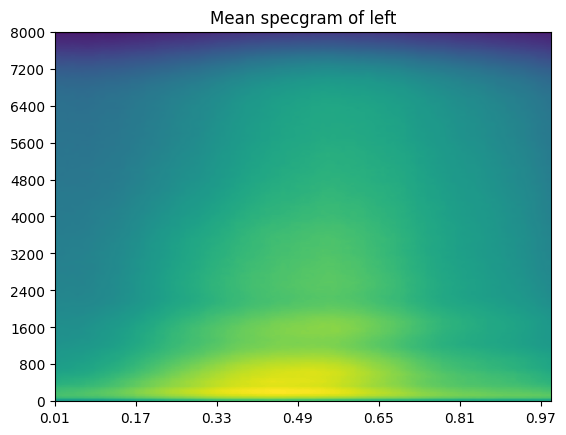

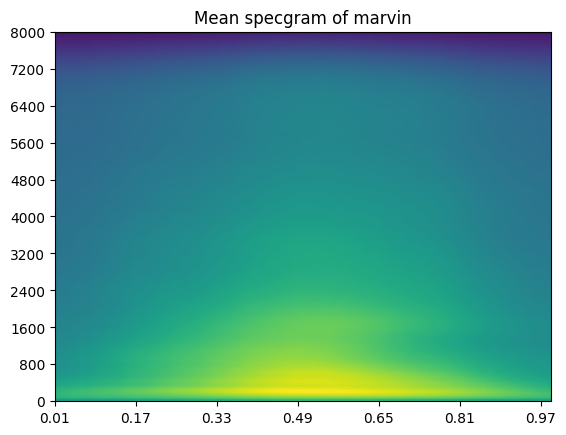

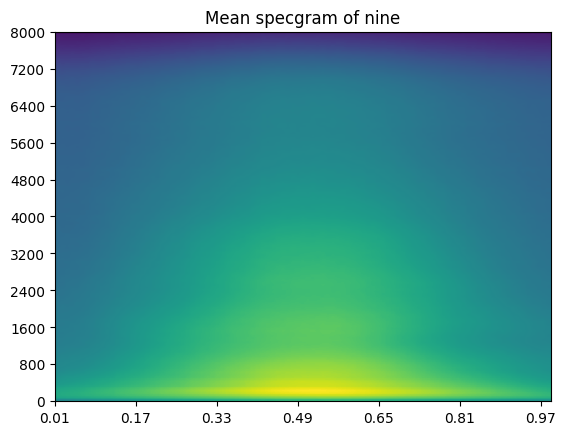

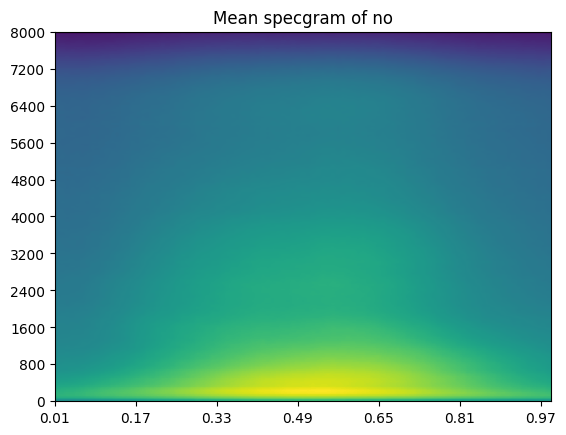

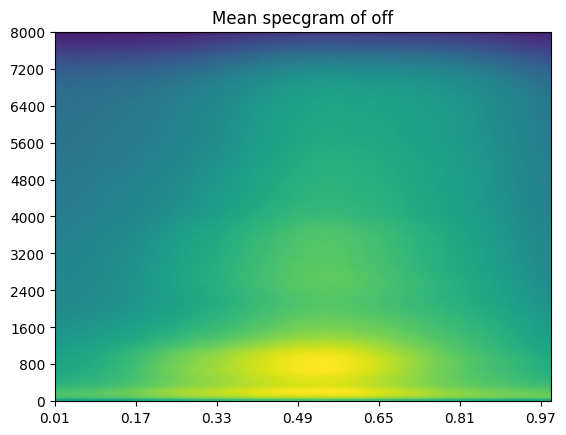

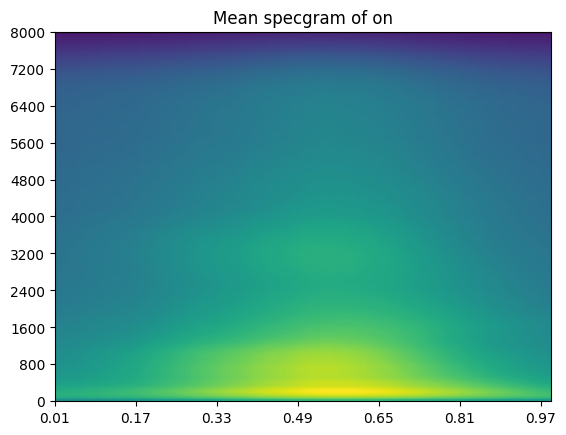

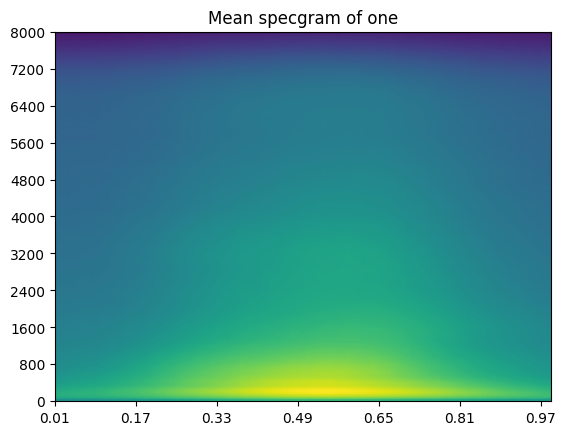

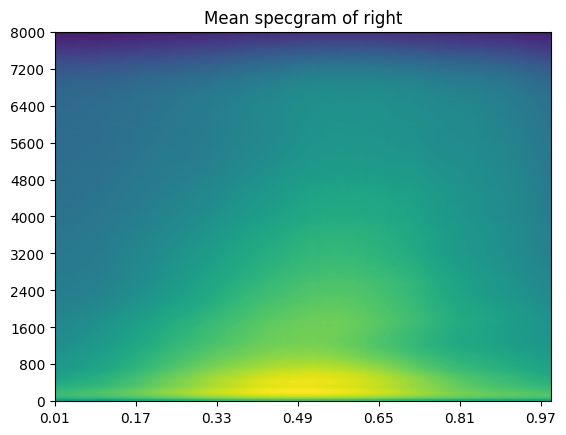

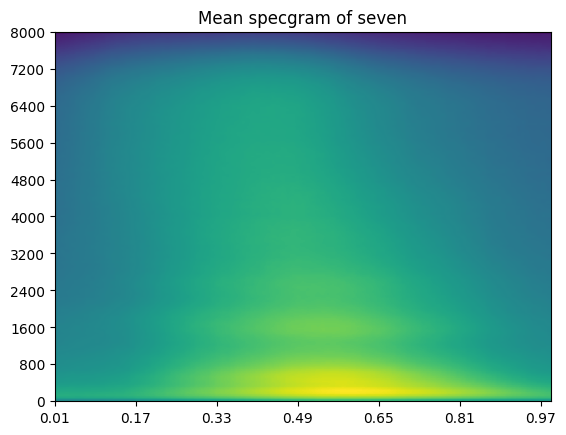

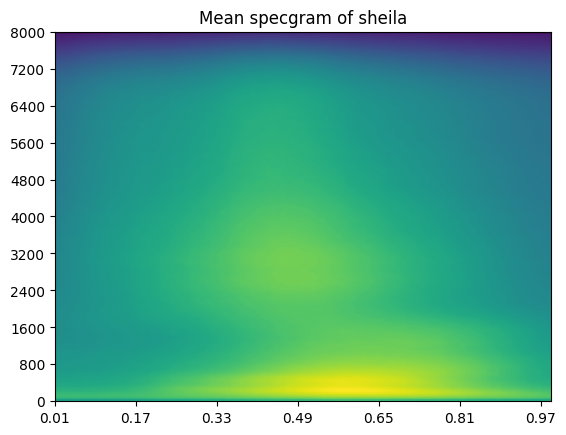

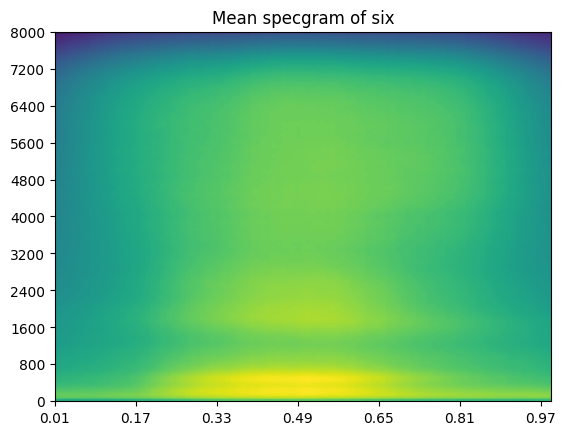

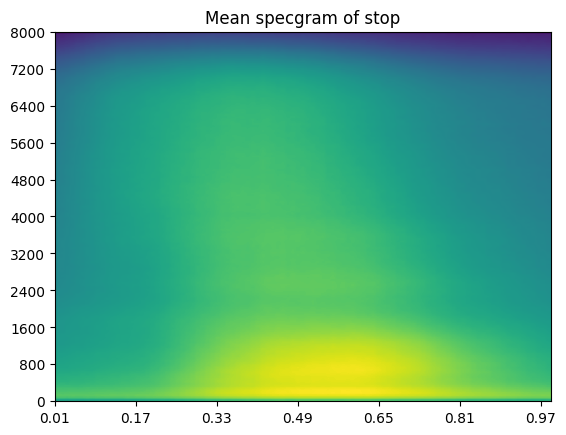

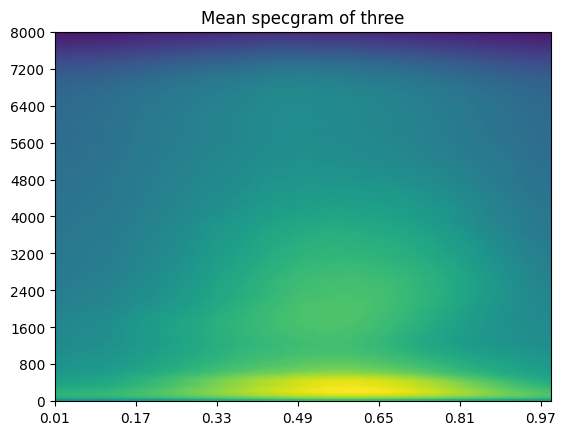

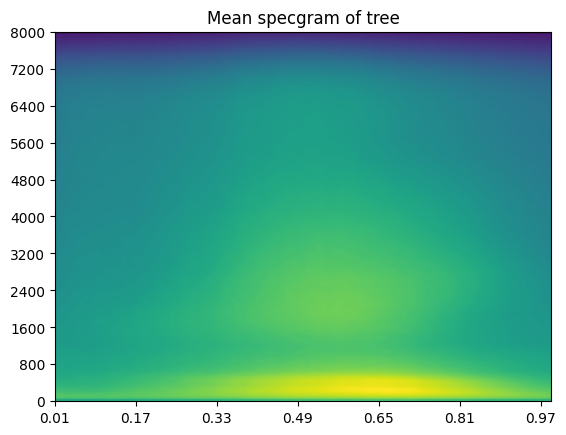

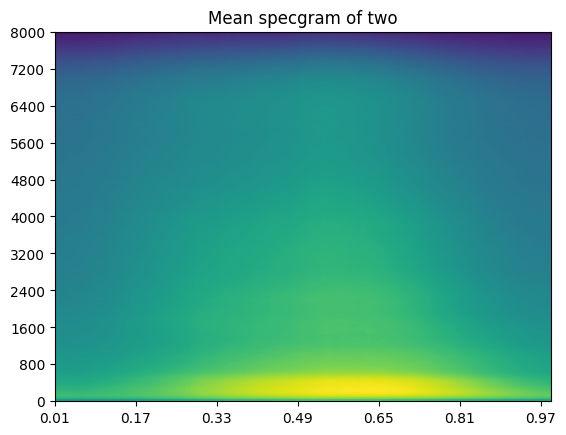

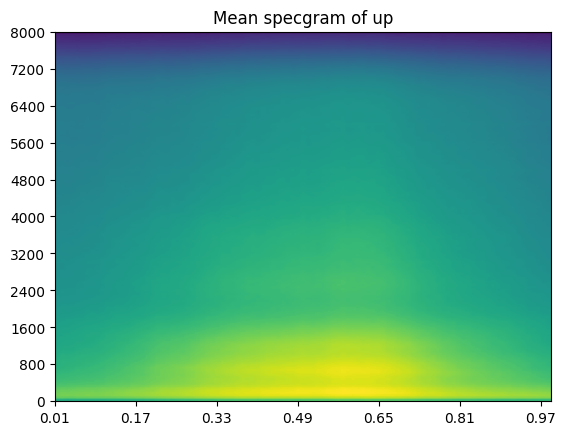

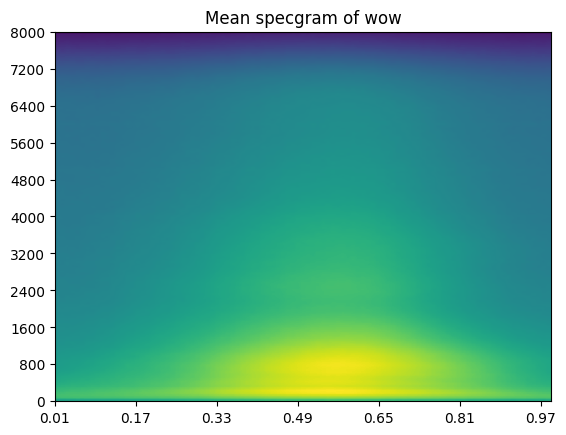

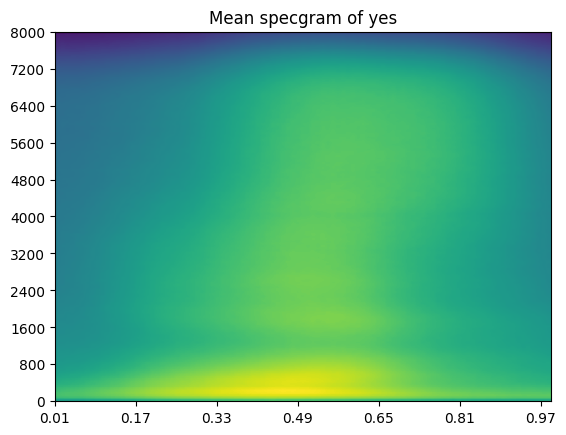

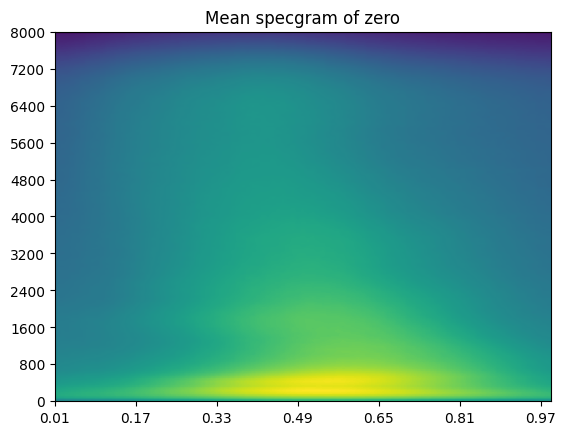

In [100]:
for label, spectro in dataset_spectro.items():#
    if label == "_background_noise_":
        continue
    plt.figure()
    plt.title("Mean specgram of " + label)
    plt.imshow(np.mean(np.array(spectro), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

# Data Loading

### Same speaker cannot appear in train and test set

According to data/challenge/train/README.md, the dataset providers already made sure that the same hash (speaker) only appears in either of the train, test or validation set.
We just have to use their validation and test lists to split the data accordingly. The split for testing and and validation is both 10% each of the dataset.

In [4]:
def read_file_paths(file_path):
    with open(file_path, "r") as file:
        paths = [line.strip() for line in file.readlines()]
    return paths

train_dir_path = Path(Path('.').resolve().parent, "data/challenge/train/")

testing_list = read_file_paths(Path(train_dir_path, "testing_list.txt"))
validation_list = read_file_paths(Path(train_dir_path, "validation_list.txt"))

def move_files(original_dir, files_list, destination_dir):
    for file_path in files_list:
        source_path = Path(original_dir, file_path)
        destination_path = Path(destination_dir, file_path)
        destination_folder = os.path.dirname(destination_path)
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        shutil.move(source_path, destination_path)

In [5]:
original_dir = train_path
validation_dir = Path(Path('.').resolve().parent, "data/challenge/validation/audio")
test_dir = Path(Path('.').resolve().parent, "data/challenge/our_test/audio")

In [5]:
move_files(original_dir, validation_list, validation_dir)
move_files(original_dir, testing_list, test_dir)

In [7]:
# Remove background noise
shutil.rmtree(Path(train_path, "_background_noise_"))

In [6]:
# Set all random seeds (Python, NumPy, and TF)
keras.utils.set_random_seed(42)

dataset_variables = { # Interesting parameters I might want to change later
  "batch_size": 32, # Size of the batches of data. Defaults to 32. If None, the data will not be batched (the dataset will yield individual samples).
  "label_mode": "categorical",
  #"ragged": True # Whether to return a Ragged dataset (where each sequence has its own length)
  # "sampling_rate": 16000, # breaks because of bug https://github.com/keras-team/tf-keras/issues/100
  "output_sequence_length": 16000 # should be one second?
}

train_dataset = keras.utils.audio_dataset_from_directory(
    train_path,
    **dataset_variables,
)
validation_dataset = keras.utils.audio_dataset_from_directory(
    validation_dir,
    **dataset_variables,
)
test_dataset = keras.utils.audio_dataset_from_directory(
    test_dir,
    **dataset_variables,
)
classes = train_dataset.class_names

Found 51088 files belonging to 30 classes.
Found 6798 files belonging to 30 classes.
Found 6835 files belonging to 30 classes.


In [ ]:
print(classes)
print(train_dataset.element_spec)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30), dtype=tf.float32, name=None))


## CNN
### Preparation
We train a CNN to classify the speech data. The following code is adapted from https://www.tensorflow.org/tutorials/audio/simple_audio

We see from `train_dataset.element_spec`, that we only have one audio channel, so we flatten the input.

In [7]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# Squeeze and use autotune for more efficient training
train_dataset = train_dataset.map(squeeze, tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(squeeze, tf.data.AUTOTUNE)
test_dataset = test_dataset.map(squeeze, tf.data.AUTOTUNE)

In [8]:
train_dataset.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 30), dtype=tf.float32, name=None))

We need to create spectrogram datasets from the loaded datasets

In [14]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_dataset)
validation_spectrogram_ds = make_spec_ds(validation_dataset)
test_spectrogram_ds = make_spec_ds(test_dataset)


### Create and train the CNN
Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:

In [15]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
validation_spectrogram_ds = validation_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

From https://www.tensorflow.org/tutorials/audio/simple_audio#build_and_train_the_model:

For the model, we use a simple convolutional neural network (CNN), since we have transformed the audio files into spectrogram images.

The `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [17]:
# Model gained and adapted from https://www.tensorflow.org/tutorials/audio/simple_audio#build_and_train_the_model
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(classes)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,449 (6.21 MB)

 Trainable params: 1,628,446 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

In [24]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True), # Does it apply for our model?
    metrics=['accuracy'],
)

In [25]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=validation_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.2734 - loss: 2.5575 - val_accuracy: 0.7246 - val_loss: 1.0159
Epoch 2/10
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - accuracy: 0.6424 - loss: 1.1808 - val_accuracy: 0.7891 - val_loss: 0.7646
Epoch 3/10
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - accuracy: 0.7168 - loss: 0.9220 - val_accuracy: 0.8114 - val_loss: 0.6523
Epoch 4/10
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.7567 - loss: 0.7990 - val_accuracy: 0.8330 - val_loss: 0.5994
Epoch 5/10
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.7865 - loss: 0.7000 - val_accuracy: 0.8429 - val_loss: 0.5725
Epoch 6/10
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 0.8001 - loss: 0.6484 - val_accuracy: 0.8477 - val_loss: 0.5469
Epoch 7/10
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.8117 - loss: 0.6004 - val_accuracy: 0.8503 - val_loss: 0.5296
Epoch 8/10
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.8228 -

Text(0, 0.5, 'Accuracy [%]')

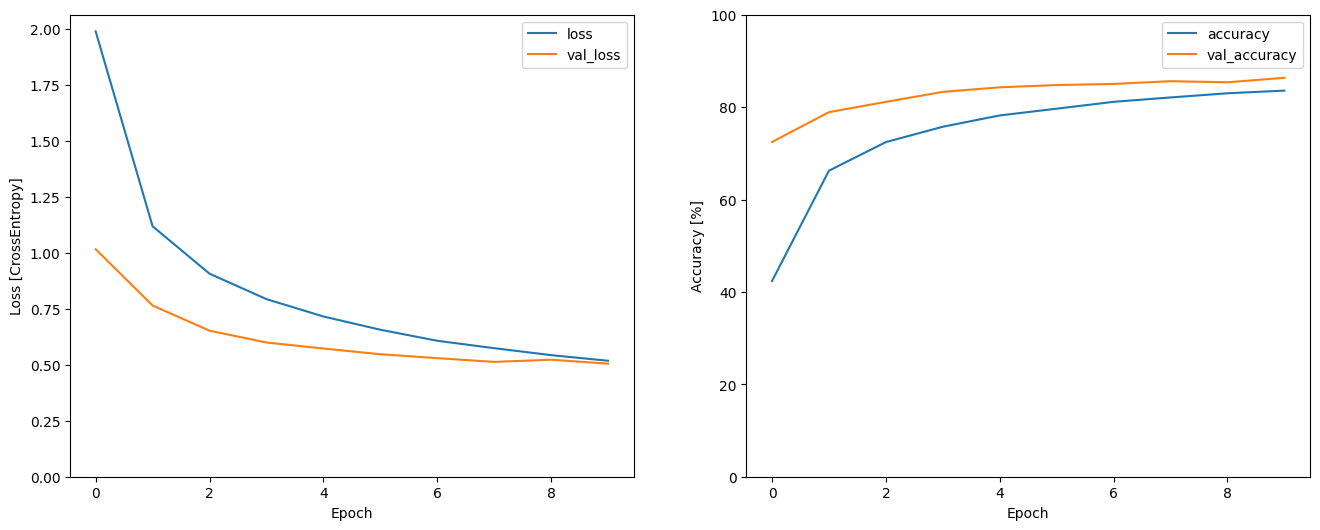

In [26]:
# Plot code from https://www.tensorflow.org/tutorials/audio/simple_audio#build_and_train_the_model
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


## Evaluation

In [27]:
model.evaluate(test_spectrogram_ds, return_dict=True)

214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8613 - loss: 0.5122


{'accuracy': 0.8512070178985596, 'loss': 0.5520240664482117}

### Confusion matrix

In [41]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_test = [] # ?

  1/214 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[]


In [42]:
# ConfusionMatrixDisplay